In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from options.test_options import TestOptions
from models import create_model
from data.knee_dataset import PixDataset
import sys
from ptoa.data.knee_monai import KneeDataset, Knee
import pandas as pd
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import torch
from matplotlib.lines import Line2D
import numpy as np
import argparse
import ast
import sklearn
import os
import glob
import re

from myutil import load_opts, make_rgb, add_mask, plots, center_of_mass, roi, roi_combined, scale, dice_fn
# from pred_cgan_dice import dice_2d

# Postprocessing
* cartilage seg
* boneseg erosion / dilation
* square crop
* blur
* binarization threshold

# Load `npz`

In [17]:
task = 'translateall'
epoch_ndx = 500
lamb = 10

In [18]:
# HAKAN 2
df = pd.read_csv('/home/yua4/bip_submission/hakan_bmel_intra_nifti.csv', na_values='None')
df = df[df['base'] != 'comet-patient-ccf-015-20210920-knee']


In [19]:
knees_test = [Knee(base) for base in df['base']]

In [20]:
ds = PixDataset(img_size=320, knees=knees_test, task='translatebone')

SliceDataset.tx: 100%|███████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.82it/s]


In [21]:
preds = glob.glob(f'preds/{task}_E{epoch_ndx:04d}_L{lamb}/*')

# Options

In [22]:
opt = load_opts(
    f'0128_{lamb}_{task}',
    epoch=epoch_ndx,
    num_threads = 0,   # test code only supports num_threads = 0
    batch_size = 1,    # test code only supports batch_size = 1
    serial_batches = True,  # disable data shuffling; comment this line if results on randomly chosen images are needed.
    no_flip = True,    # no flip; comment this line if results on flipped images are needed.
    display_id = -1,   # no visdom display; the test code saves the results to a HTML file.
    isTrain = False,
)
opt

Namespace(batch_size=1, beta1=0.5, checkpoints_dir='./checkpoints', continue_train=False, crop_size=320, dataroot='translateall', dataset_mode='aligned', direction='AtoB', display_env='main', display_freq=400, display_id=-1, display_ncols=4, display_port=8097, display_server='http://localhost', display_winsize=256, epoch=500, epoch_count=1, gan_mode='vanilla', gpu_ids=[0], init_gain=0.02, init_type='normal', input_nc=1, isTrain=False, lambda_L1=10.0, load_iter=0, load_size=320, lr=0.0005, lr_decay_iters=50, lr_policy='linear', max_dataset_size='inf', model='pix2pix', n_epochs=10000, n_epochs_decay=100, n_layers_D=3, name='0128_10_translateall', ndf=64, netD='n_layers', netG='unet_320', ngf=64, no_boneseg=False, no_dropout=False, no_flip=True, no_html=False, norm='batch', num_threads=0, output_nc=1, phase='train', pool_size=0, preprocess='resize_and_crop', print_freq=100, save_by_iter=False, save_epoch_freq=5, save_latest_freq=5000, serial_batches=True, suffix='', update_html_freq=1000,

In [23]:
ds.task = opt.dataroot
ds.img_size = opt.crop_size
# dl = DataLoader(ds, batch_size=opt.batch_size, shuffle=False)

# Pred & DICE

In [24]:
def calc_dice(pred, real, base):
    pass

In [25]:
# GET DATA & PRED
slcs = []
for data in ds:
    slcs.append({
        'base': data['base'],
        'id': data['id'],
        'real_tse': (data['B'][0].detach().cpu().numpy() + 1) / 2,
        'fake_tse': np.load([p for p in preds if data['id'] in p][0])['arr_0'],
        'bmel': data['bmel'][0].detach().cpu().numpy(),
        'bone': data['bone'][0].detach().cpu().numpy(),
        # 'mask': data['mask'][0].detach().cpu().numpy(),
    })

In [26]:
volumes = []
for base in df['base']:
    slcs_current = [slc for slc in slcs if slc['base'] == base]
    volumes.append({
        'base': base,
        'real_tse': np.array([slc['real_tse'] for slc in slcs_current]),
        'fake_tse': np.array([slc['fake_tse'] for slc in slcs_current]),
        'bmel': np.array([slc['bmel'] for slc in slcs_current]),
        'bone': np.array([slc['bone'] for slc in slcs_current]),
    })

In [ ]:
# APPLY POSTPROC AND CALC DICE
dices = {thresh: [] for thresh in [.11]}
for slc in tqdm.tqdm(slcs):
    # if slc['id'] != 'comet-patient-ccf-001-20210601-knee-slc10': continue
    if slc['bmel'].sum() <= 0: continue
    
    # COMPUTE RAW PRED
    # pred = scale(slc['real_tse'], new_min=0., new_max=1.) - scale(slc['fake_tse'], new_min=0., new_max=1.)
    pred = slc['real_tse'] - slc['fake_tse']
    pred = np.where(slc['bone'], pred, -2)
    mask_roi_combined = roi_combined(slc['bmel'])
    pred = np.where(mask_roi_combined, pred, -2)
        
    # BINARIZE PRED
    for thresh in dices:
        pred_binary = pred > thresh
        dice = dice_fn(slc['bmel'], pred_binary)
        dices[thresh].append(dice)
        plots([slc['real_tse'], slc['fake_tse'], mask_roi_combined, pred_binary])
    
        # plt.plot(dices.keys(), dices.values())
dice_means = {k:np.nanmean(v) for k,v in dices.items()}
# plt.plot(dice_means.keys(), dice_means.values())

In [39]:
dice_means

{-0.0: 0.15939407285518922,
 0.01: 0.16609810239533707,
 0.02: 0.17508003949769718,
 0.03: 0.1859114734336033,
 0.04: 0.19940949216317394,
 0.05: 0.21428594847294974,
 0.06: 0.22966614748043057,
 0.07: 0.24453908227722018,
 0.08: 0.2568805638472934,
 0.09: 0.26601574597624617,
 0.1: 0.27084707613569975,
 0.11: 0.27289085641329575,
 0.12: 0.267690050034651,
 0.13: 0.26077678591054493,
 0.14: 0.24689745963199838,
 0.15: 0.23072135723146,
 0.16: 0.2103764519473737,
 0.17: 0.18807211014331554,
 0.18: 0.16687486560326237,
 0.19: 0.14813759056570744,
 0.2: 0.1305891666538871,
 0.21: 0.11412433088009986,
 0.22: 0.09828145838405013,
 0.23: 0.08595633358669581,
 0.24: 0.07294059473994485,
 0.25: 0.06327403252743322,
 0.26: 0.053962871346912085,
 0.27: 0.046481023837897005,
 0.28: 0.03863375672256021,
 0.29: 0.03390373596825444,
 0.3: 0.02960442979353189,
 0.31: 0.02550298339267105,
 0.32: 0.021859873814699383,
 0.33: 0.01877474089773777,
 0.34: 0.01623980645273336,
 0.35000000000000003: 0.01396

In [90]:
# POSTPROC 3D
epistemic = dict()
for base in bases:
    epistemic[base] = np.array([x['tse'] for x in real if base in x['id']]) - np.array([x['tse'] for x in pred if base in x['id']])
    

In [61]:
# POSTPROC 2D
epistemic = np.array([x['tse'] for x in real]) - np.array([x['tse'] for x in pred])
pred_binary = 
# pred = np.array([x['tse'] for x in pred])
# real = np.array([x['tse'] for x in real])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 1839.34it/s]


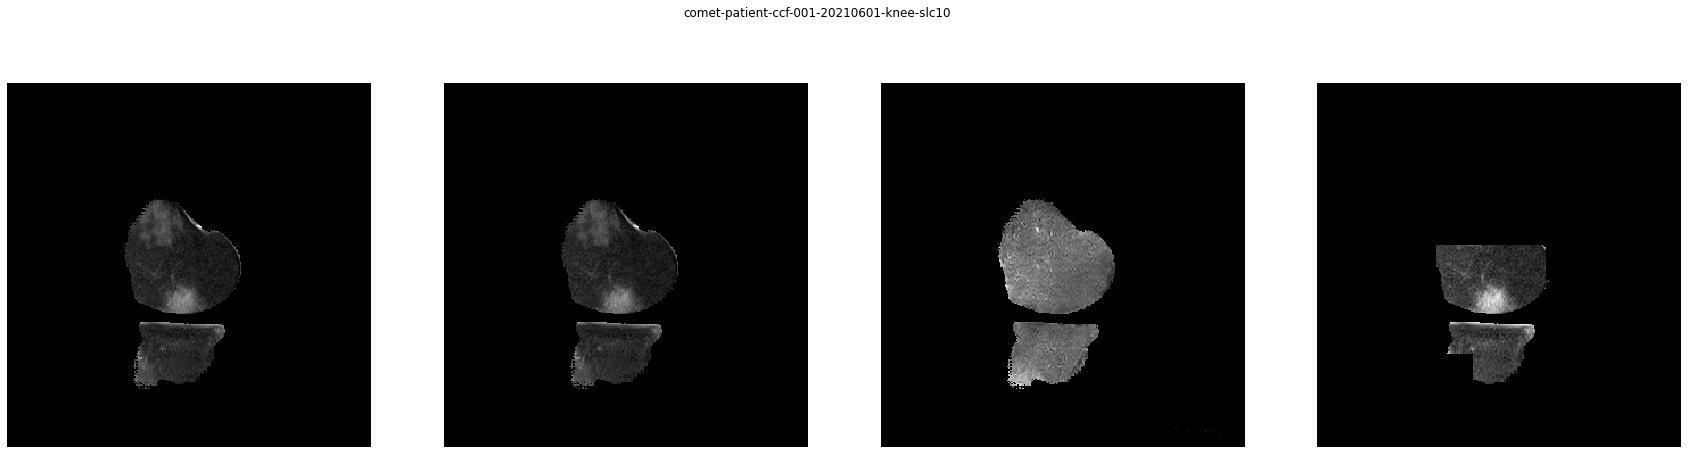

In [31]:
for data in tqdm.tqdm(ds):
    # FILTER
    # if data['bmel'].sum() <= 0: continue
    # if data['base'][sample_ndx] != 'comet-patient-ccf-001-20210601-knee': continue
    if data['id'] != 'comet-patient-ccf-001-20210601-knee-slc10': continue
    
    # GET DATA
    real_dess = (data['A'][0].detach().cpu().numpy() + 1) / 2
    real_tse = (data['B'][0].detach().cpu().numpy() + 1) / 2
    bmel = data['bmel'][0].detach().cpu().numpy()
    bone = data['bone'][0].detach().cpu().numpy()
    mask = data['mask'][0].detach().cpu().numpy()
    # GET PRED
    fake_tse = np.load([p for p in preds if data['id'] in p][0])['arr_0']    
    
    # POSTPROC
    # mask_roi_combined = roi_combined(bmel)

    aleatoric = 1.
    epistemic = real_tse - fake_tse / aleatoric
    # bmel_pred = epistemic
    # bmel_pred = np.where(mask_roi_combined, bmel_pred, -1)
    # bmel_pred = np.where(bone, bmel_pred, -1)    
    # fig, ax = plots([real_tse, real_tse * bone, fake_tse, mask_roi_combined * real_tse], cbar=False, axis=False)
    # fig.suptitle(data['id'])
    
    pred.append(epistemic)
    
    
# DICE
    
    
 
    

dilated bone mask => normalize => bone mask

cartilage-preserving bone mask erosion => normalize

normalize fake-tse to minimize voxel-wise diff from real_tse

In [ ]:
model.set_input_eroded(batch)
eroded_mask = (model.image_bone[0,0].detach().cpu().to(bool))
eroded_scibilic = scibilic.clone()
eroded_scibilic[~eroded_mask] = 0